In this project my goal is to find the optimal angle and bond length of $H_\mathrm{2}O$. $H_\mathrm{2}O$ is a non collinear molecule so that the bond angle of $H-O-H$ is not $180^{o}$, so it is more difficult to find the optimal angle. Here i first using the Numpy function to obtain the value of the optimized bond angle and bond length by fitting a 3D potential energy surface of H2O, then i use VQE runtime to benchmark my ansatz to determine if my variational circuit can also produce simular minimal energy as the Numpy result. The runtime process is used to run the VQE process multiple times at different starting angle to understand which initial angle can result in the best VQE energy matching the exact diagnoalization using Numpy result. 

In [1]:
import numpy as np
import copy
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s) and check with backend can use runtime. Here the qasm simulator is used because it can run runtime
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')
runtime_backends = provider.backends(input_allowed='runtime')
print(runtime_backends)

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>]


Set up the water molecule so that we can vary the bond distance and bond angle to calculate a 3D potential energy suface to find the optimal values
for bond angle and bond length

In [2]:
# Loading the relevant libraries and define the molecular structure of H2O in Z-matrix format.Here we vary the two bond legnth at equal distances
# and the bond angle. The bond angle is varied from 30 degree to 180 degree

from qiskit import Aer
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

H2O = 'H; O 1 {}; H 2 {} 1 {}'
distance = [i * 0.1 + 0.3 for i in range(20)]
angle = [j * 30 for j in range(1,7,1)]


/opt/conda/lib/python3.8/site-packages/pyscf/lib/misc.py:47: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [111]:
# In this step we calculate the minimum energy of the H2O molecule at different angle and bond lengths using the Numpy exact diagnolization
# The hamiltonian is mapped to qubit basis using the Parity mapper from the intial second quantization format
# The core elevtrons are frozen to reduce the number of qubits for calculation

converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
numpy_solver = NumPyMinimumEigensolver()
energies_exact = []
for a in angle:
    for d in distance:
        driver = PySCFDriver(H2O.format(d,d,a),unit=UnitsType.ANGSTROM, basis='sto3g')
        problem = ElectronicStructureProblem(driver, q_molecule_transformers=[FreezeCoreTransformer(remove_orbitals=[4,5,6])])
        second_q_ops = problem.second_q_ops()
        main_op = second_q_ops[0]
        num_particles = (problem.molecule_data_transformed.num_alpha,problem.molecule_data_transformed.num_beta)
        qubit_op = converter.convert(main_op, num_particles=num_particles)
        calc_exact = GroundStateEigensolver(converter,numpy_solver)
        res_exact = calc_exact.solve(problem)
        energies_exact.append(res_exact.total_energies[0])

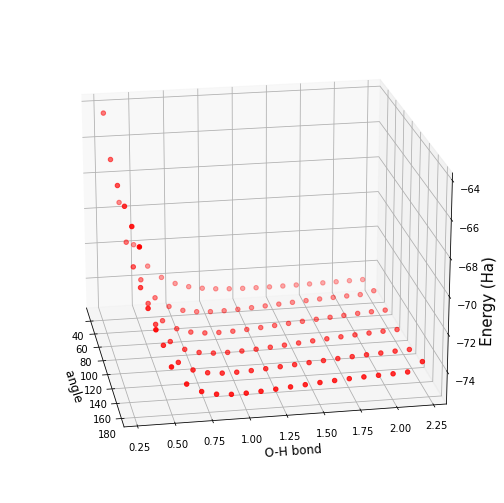

<Figure size 432x288 with 0 Axes>

In [112]:
# Here we plot the data points of the minimum energy based on exact diagnolization for different angles and distances
 
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
X = np.array(np.repeat(angle,len(distance)))
Y = np.array(distance*len(angle))
Z = np.array(energies_exact)
fig = plt.figure(figsize =(16, 9))  
ax = plt.axes(projection ='3d')
ax.view_init(20, -10)
ax.set_xlabel('angle ', fontsize=12, rotation=150)
ax.set_ylabel('O-H bond',fontsize=12, rotation=150)
ax.set_zlabel('Energy (Ha)', fontsize=15, rotation=60)
surf = ax.scatter(X, Y, Z, color='red')  
fig = plt.figure()
plt.show()

In [113]:
# To determine the optimal bond angle and distances in the potential energy surface, the 3D data ponints are fitted to a 3D function using linear regression
# The 3D function has the format of a1/(X^2) + a2/(Y^2) + a3/(X^3) + a4/(Y^3) + a5/(x^4.5) + a6/(y^4.5)

from sklearn import linear_model
x1, y1, z1 = X.flatten(), Y.flatten(), Z.flatten()
x11, y11, x12, y12, x13, y13, x14, y14 = 1/(x1**2), 1/(y1**2), 1/(x1**3), 1/(y1**3), 1/(x1**4), 1/(y1**4), 1/(x1**4.5), 1/(y1**4.5)
X_data = np.array([x11, y11, x12, y12, x13, y13, x14, y14]).T  
Y_data = z1
reg = linear_model.LinearRegression().fit(X_data, Y_data)
print("coefficients of equation of plane, (a1, a2, a3, a4, a5, a6): ", reg.coef_)
print("value of intercept, c:", reg.intercept_)

coefficients of equation of plane, (a1, a2, a3, a4, a5, a6):  [-2.45146825e+04 -4.13495495e+00  3.70121505e+06  4.64129647e+00
 -2.55000591e+08 -2.12934816e+00  9.09173837e+08  6.41499652e-01]
value of intercept, c: -73.58769341533467


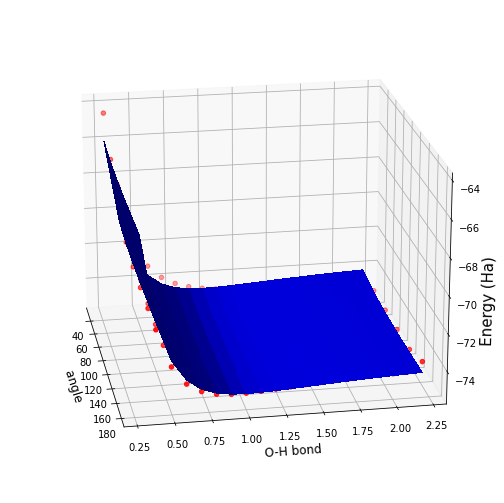

In [114]:
# Plot the 3D function and the data points of minimum energy at different bond length and angles 

import matplotlib as mpl
fig = plt.figure(figsize =(16, 9))  
ax = plt.axes(projection ='3d')
ax.view_init(20, -10)
ax.set_xlabel('angle ', fontsize=12, rotation=150)
ax.set_ylabel('O-H bond',fontsize=12, rotation=150)
ax.set_zlabel('Energy (Ha)', fontsize=15, rotation=60)
def z_pred(x, y):
    z_func = reg.coef_[0]*1/(X**2) + reg.coef_[1]*1/(Y**2) + reg.coef_[2]*1/(X**3) + reg.coef_[3]*1/(Y**3) + reg.coef_[4]*1/(X**4) + reg.coef_[5]*1/(Y**4) + reg.coef_[6]*1/(X**4.5) + reg.coef_[7]*1/(Y**4.5) + reg.intercept_
    return z_func
[x_grid, y_grid] = np.meshgrid(X, Y)
z_grid = z_pred(X, Y)
ax.plot_trisurf(X, Y, z_grid, linewidth = 0, antialiased = False,color='blue',edgecolor=None, label = 'prediction')
ax.scatter(X, Y, Z, color = 'red', label='data')
plt.show()

In [115]:
# Find the optimal bond length and angle by finding the minimum of the 3D function
# Compare the minium bond distance and the angle with the values from data array

import scipy.optimize as optimize

def fit(params):
    x, y = params
    return reg.coef_[0]*1/(x**2) + reg.coef_[1]*1/(y**2) + reg.coef_[2]*1/(x**3) + reg.coef_[3]*1/(y**3) + reg.coef_[4]*1/(x**4) + reg.coef_[5]*1/(y**4) + reg.coef_[6]*1/(x**4.5) + reg.coef_[7]*1/(y**4.5) + reg.intercept_

initial_guess = [100,0.9]
result = optimize.minimize(fit, initial_guess)
print(result)

      fun: -74.96417406426215
 hess_inv: array([[ 2.41277323e+03, -1.35401968e-01],
       [-1.35401968e-01,  2.59194460e-01]])
      jac: array([0.00000000e+00, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 78
      nit: 22
     njev: 26
   status: 0
  success: True
        x: array([108.74515985,   1.00569146])


In [105]:
# Set the optimized angle and bond length
# Here the optimized angle and bond length match the experimental value of H2O with bon angle = 104.5 and legnth of O-H bond = 0.945

optimized_angle = result['x'][0]
optimized_distance = result['x'][1]

108.85417513665914
1.005102450580927


After obtaining the minimal theoretical values for bond angle and bond legnths through classical approach using Numpy, we begin our quantum run with $runtime$ $VQE$. Here to determine the initial optimal starting angles, we used runtime for different random starting angle. To determine the best starting angles of our variational circuit in the $VQE$ run, we benchmark the result against classical values obtained from exact diagnolization using Numpy

In [118]:
# Compute the minimum energy using the optimized angle and bond length with exact diagnolization using Numpy
# Here we remove the orbitals 4,5, and 6 to reduce the number of qubits during computation

driver_optimized = PySCFDriver(H2O.format(optimized_distance,optimized_distance,optimized_angle),unit=UnitsType.ANGSTROM, basis='sto3g')
problem_optimized = ElectronicStructureProblem(driver_optimized, q_molecule_transformers=[FreezeCoreTransformer(remove_orbitals=[4,5,6])])
second_q_ops_optimized = problem_optimized.second_q_ops()
main_op_optimized = second_q_ops_optimized[0]
num_particles_optimized = (problem_optimized.molecule_data_transformed.num_alpha,problem_optimized.molecule_data_transformed.num_beta)
qubit_op_optimized = converter.convert(main_op_optimized, num_particles=num_particles_optimized)
calc_exact_optimized = GroundStateEigensolver(converter,numpy_solver)
res_exact_optimized = calc_exact_optimized.solve(problem_optimized)
print(res_exact_optimized)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -83.709197933496
  - computed part:      -13.60601137269
  - FreezeCoreTransformer extracted energy part: -70.103186560806
~ Nuclear repulsion energy (Hartree): 8.747498538596
> Total ground state energy (Hartree): -74.961699394901
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 6.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [17.70811632  0.0  1.79745608]
 
  0: 
  * Electronic dipole moment (a.u.): [18.0827398  0.0  1.27366455]
    - computed part:      [10.48572279  0.0  1.27302639]
    - FreezeCoreTransformer extracted energy part: [7.59701701  0.0  0.00063816]
  > Dipole moment (a.u.): [-0.37462348  0.0  0.52379153]  Total: 0.6439723
                 (debye): [-0.95219783  0.0  1.33134515]  Total: 1.63681417
 


In [121]:
# Create an ansatz with initial condition from Hartree Fock state

from qiskit_nature.circuit.library import HartreeFock

init_state = HartreeFock(qubit_op_optimized.num_qubits, num_particles_optimized, converter)

from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal
ansatz= TwoLocal(qubit_op.num_qubits, ['ry','rz'],['cx'], entanglement= [[0,1],[2,3],[4,5]],
                    reps= 1,insert_barriers=True)
ansatz.compose(init_state, front=True, inplace=True)
print(ansatz)

     ┌───┐┌──────────┐ ┌──────────┐ ░       ░ ┌───────────┐┌───────────┐
q_0: ┤ X ├┤ Ry(θ[0]) ├─┤ Rz(θ[6]) ├─░───■───░─┤ Ry(θ[12]) ├┤ Rz(θ[18]) ├
     ├───┤├──────────┤ ├──────────┤ ░ ┌─┴─┐ ░ ├───────────┤├───────────┤
q_1: ┤ X ├┤ Ry(θ[1]) ├─┤ Rz(θ[7]) ├─░─┤ X ├─░─┤ Ry(θ[13]) ├┤ Rz(θ[19]) ├
     ├───┤├──────────┤ ├──────────┤ ░ └───┘ ░ ├───────────┤├───────────┤
q_2: ┤ X ├┤ Ry(θ[2]) ├─┤ Rz(θ[8]) ├─░───■───░─┤ Ry(θ[14]) ├┤ Rz(θ[20]) ├
     ├───┤├──────────┤ ├──────────┤ ░ ┌─┴─┐ ░ ├───────────┤├───────────┤
q_3: ┤ X ├┤ Ry(θ[3]) ├─┤ Rz(θ[9]) ├─░─┤ X ├─░─┤ Ry(θ[15]) ├┤ Rz(θ[21]) ├
     ├───┤├──────────┤┌┴──────────┤ ░ └───┘ ░ ├───────────┤├───────────┤
q_4: ┤ X ├┤ Ry(θ[4]) ├┤ Rz(θ[10]) ├─░───■───░─┤ Ry(θ[16]) ├┤ Rz(θ[22]) ├
     ├───┤├──────────┤├───────────┤ ░ ┌─┴─┐ ░ ├───────────┤├───────────┤
q_5: ┤ X ├┤ Ry(θ[5]) ├┤ Rz(θ[11]) ├─░─┤ X ├─░─┤ Ry(θ[17]) ├┤ Rz(θ[23]) ├
     └───┘└──────────┘└───────────┘ ░ └───┘ ░ └───────────┘└───────────┘


In [122]:
# Using runtime program to compute the minimum eigenvalue using the customized anstaz over 4 iterations to obtain the best eigenvalue

from qiskit_nature.runtime import VQEProgram
runtime = []
for i in range(0,4,1):
    intermediate_info = {
        'nfev': [],
        'parameters': [],
        'energy': [],
        'stddev': []
    }
    def callback(nfev, parameters, energy, stddev):
        intermediate_info['nfev'].append(nfev)
        intermediate_info['parameters'].append(parameters)
        intermediate_info['energy'].append(energy)
        intermediate_info['stddev'].append(stddev)
    np.random.seed(10)  # seed for reproducibility
    initial_point = np.random.random(ansatz.num_parameters)
    measurement_error_mitigation = True
    optimizer = {'name': 'SPSA','maxiter': 300}
    runtime_vqe = VQEProgram(ansatz=ansatz,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=backend,
                         shots=8192,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=callback)
    runtime_result = runtime_vqe.compute_minimum_eigenvalue(qubit_op_optimized)
    runtime.append(runtime_result)

In [123]:
# Obtain the list of eigenvalues, eiegenstates,and statevectors for the different iteration

qubit_list = []
eigenstate_list = []
eigenvalue_list = []
for l in runtime:
    qubit_number = list(l.eigenstate.keys())
    qubit_list.append(qubit_number)
    eigenstate_value = list(l.eigenstate.values())
    eigenstate_list.append(eigenstate_value)
    eigen_value = l.eigenvalue.real
    eigenvalue_list.append(eigen_value)
print(eigenvalue_list)

[-13.600194341155728, -13.499524432416639, -13.586526255117697, -13.5997952233699]


In [124]:
# Calculate the difference between reference value (the Numpy diagnolization) and the eigenvalue obtained from different VQE runs
# The best value is selected based on the minimula energy difference between VQE and exact diagnolization

reference_value = float(res_exact_optimized.eigenenergies.real)
eigenvalue_difference = []
for j in eigenvalue_list:
    difference = j - reference_value
    eigenvalue_difference.append(difference*1000)

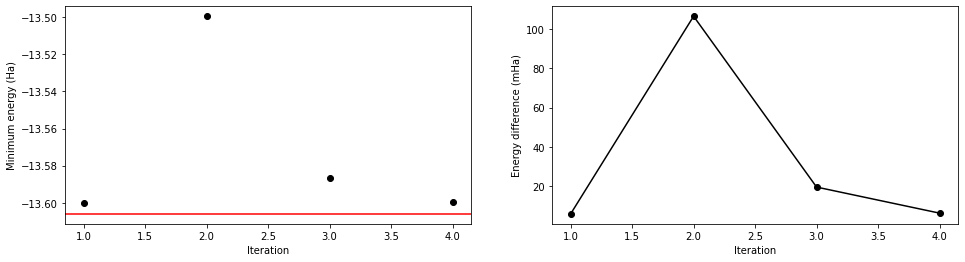

In [202]:
# Plot the energy difference and eigenvalues for different VQE run. The reference value is plotted as the red line on the graph on the left
# The best VQE run result is the value which minimizes the energy difference between VQE and exact diagnolization
iteration = range(1,5,1)
figure = plt.figure(figsize=(16,4))
ax0 = figure.add_subplot(121)
ax1 = figure.add_subplot(122)
ax0.plot(iteration,eigenvalue_list,'o',color='black')
ax0.axhline(y=reference_value, color='r', linestyle='-')
ax0.set_ylabel('Minimum energy (Ha)')
ax0.set_xlabel('Iteration')
ax1.plot(iteration,eigenvalue_difference,'-o',color='black')
ax1.set_ylabel('Energy difference (mHa)')
ax1.set_xlabel('Iteration')
figure.show()

In [200]:
for value_index in range(0,4,1):
    Max_value = max(eigenstate_list[value_index])
    Second_max_value = max(n for n in eigenstate_list[value_index] if n!=Max_value)
    difference_probability = Max_value - Second_max_value
    print('The max probability for the statevector of  iteration {} is {}'.format(value_index+1, Max_value))
    print('The second max probability for the statevector of  iteration {} is {}'.format(value_index+1, Second_max_value))
    print('The probability difference for the most probable and second most probable statevector of  iteration {} is {}'.format(value_index+1, difference_probability))


The max probability for the statevector of  iteration 1 is 0.4051969391326999
The second max probability for the statevector of  iteration 1 is 0.3761375867983654
The probability difference for the most probable and second most probable statevector of  iteration 1 is 0.029059352334334487
The max probability for the statevector of  iteration 2 is 0.33602833242796554
The second max probability for the statevector of  iteration 2 is 0.27621358757963654
The probability difference for the most probable and second most probable statevector of  iteration 2 is 0.05981474484832899
The max probability for the statevector of  iteration 3 is 0.5454221639194772
The second max probability for the statevector of  iteration 3 is 0.4294743746715886
The probability difference for the most probable and second most probable statevector of  iteration 3 is 0.11594778924788857
The max probability for the statevector of  iteration 4 is 0.5550724875807165
The second max probability for the statevector of  iter

Finally we check if the optimal initial starting points of our variational circuit is still optimal even when the molecule structure changes

In [128]:
# Rerun the potential energy surface but only varies the angle while keeping the bond-length the same

angle_list = [k * 10 for k in range(1,19,1)]
exact_energies_angle = []
for degree in angle_list:
    driver_angle = PySCFDriver(H2O.format(optimized_distance,optimized_distance,degree),unit=UnitsType.ANGSTROM, basis='sto3g')
    problem_angle = ElectronicStructureProblem(driver_angle, q_molecule_transformers=[FreezeCoreTransformer(remove_orbitals=[4,5,6])])
    second_q_ops_angle = problem_angle.second_q_ops()
    main_op_angle = second_q_ops_angle[0]
    num_particles_angle = (problem_angle.molecule_data_transformed.num_alpha,problem_angle.molecule_data_transformed.num_beta)
    qubit_op_angle = converter.convert(main_op_angle, num_particles=num_particles_angle)
    calc_exact_angle = GroundStateEigensolver(converter,numpy_solver)
    res_exact_angle = calc_exact_angle.solve(problem_angle)
    exact_energies_angle.append(res_exact_angle)


In [131]:
# Using the optimal point of iteration 1 in runtime VQE as the starting point to calculate the potential energy surface using VQE

runtime_vqe_angle = []
for vqe_angle in angle_list:
    intermediate_info_angle = {
        'nfev': [],
        'parameters': [],
        'energy': [],
        'stddev': []
    }
    def callback_angle(nfev, parameters, energy, stddev):
        intermediate_info_angle['nfev'].append(nfev)
        intermediate_info_angle['parameters'].append(parameters)
        intermediate_info_angle['energy'].append(energy)
        intermediate_info_angle['stddev'].append(stddev)
    optimizer = {'name': 'SPSA','maxiter': 500}
    driver_vqe_angle = PySCFDriver(H2O.format(optimized_distance,optimized_distance,vqe_angle),unit=UnitsType.ANGSTROM, basis='sto3g')
    problem_vqe_angle = ElectronicStructureProblem(driver_vqe_angle, q_molecule_transformers=[FreezeCoreTransformer(remove_orbitals=[4,5,6])])
    second_q_ops_vqe_angle = problem_vqe_angle.second_q_ops()
    main_op_vqe_angle = second_q_ops_vqe_angle[0]
    qubit_op_vqe_angle = converter.convert(main_op_vqe_angle, num_particles=num_particles_optimized)
    runtime_angle_vqe = VQEProgram(ansatz=ansatz,
                         optimizer=optimizer,
                         initial_point=runtime[0].optimal_point,
                         provider=provider,
                         backend=backend,
                         shots=8192,
                         measurement_error_mitigation=True,
                         callback=callback_angle)
    runtime_result_angle = runtime_angle_vqe.compute_minimum_eigenvalue(qubit_op_vqe_angle)
    runtime_vqe_angle.append(runtime_result_angle)

In [161]:
runtime_eigenenergies_angle = []
exact_total_eigenenergies_angle = []
frozen_orbital_energies = []
nuclear_energies = []
for i in range(len(runtime_vqe_angle)):
    runtime_eigenenergies_angle.append(runtime_vqe_angle[i].eigenvalue.real)
for j in range(len(exact_energies_angle)):
    exact_total_eigenenergies_angle.append(exact_energies_angle[j].total_energies)
    frozen_orbital_energies.append(exact_energies_angle[j].electronic_energies-exact_energies_angle[j].computed_energies)
    nuclear_energies.append(exact_energies_angle[j].nuclear_repulsion_energy)
runtime_total_energies_angle = [k+l+m for k, l, m in zip(runtime_eigenenergies_angle,frozen_orbital_energies,nuclear_energies)]

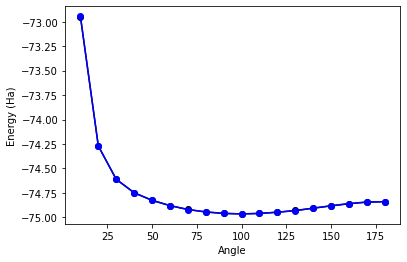

In [166]:
# Plotting the minimal total energies from VQE and Numpy run for water at different angles
# The VQE results match the classical numput result 

plt.xlabel('Angle')
plt.ylabel('Energy (Ha)')
plt.plot(angle_list,exact_eigenenergies_angle,'-o', color='black')
plt.plot(angle_list,runtime_total_energies_angle, '-o', color='blue')
plt.show()